In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
import pycountry
from scipy import stats

# Configuración visual
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')
plt.rcParams['figure.figsize'] = (12, 7)
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12

# Funciones de formato para ejes
def formato_millones(x, pos):
    return f'{x/1e6:.1f}M' if x >= 1e6 else f'{x/1e3:.0f}k'

def formato_miles_millones(x, pos):
    return f'{x/1e9:.1f}B' if x >= 1e9 else f'{x/1e6:.1f}M'

# Función para convertir códigos ISO2 a ISO3
def iso2_to_iso3(code):
    try:
        return pycountry.countries.get(alpha_2=code).alpha_3
    except:
        return None

In [3]:
# Cargar datos económicos (PIB)
pib_path = '../../data/fuentes/economicos/API_NY.GDP.MKTP.CD_DS2_en_excel_v2_85096.xls'
df_pib = pd.read_excel(pib_path, sheet_name='Data', skiprows=3)

# Mostrar las primeras filas y la información del dataset
print("Dataset de PIB:")
print(f"Dimensiones: {df_pib.shape}")
print("\nPrimeras filas:")
display(df_pib.head())
print("\nColumnas:")
display(df_pib.columns.tolist())

Dataset de PIB:
Dimensiones: (266, 69)

Primeras filas:


,Country Name,Country Code,Indicator Name,Indicator Code,1960,1961,1962,1963,1964,1965,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
0,Aruba,ABW,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,2.962907e+09,2.983635e+09,3.092429e+09,3.276184e+09,3.395799e+09,2.481857e+09,2.929447e+09,3.279344e+09,3.648573e+09,NaN
1,Africa Eastern and Southern,AFE,GDP (current US$),NY.GDP.MKTP.CD,2.421063e+10,2.496398e+10,2.707880e+10,3.177575e+10,3.028579e+10,3.381317e+10,...,8.982778e+11,8.289428e+11,9.729989e+11,1.012306e+12,1.009721e+12,9.333918e+11,1.085745e+12,1.191423e+12,1.245472e+12,NaN
2,Afghanistan,AFG,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,1.913422e+10,1.811657e+10,1.875346e+10,1.805322e+10,1.879944e+10,1.995593e+10,1.426000e+10,1.449724e+10,1.723305e+10,NaN
3,Africa Western and Central,AFW,GDP (current US$),NY.GDP.MKTP.CD,1.190495e+10,1.270788e+10,1.363076e+10,1.446909e+10,1.580376e+10,1.692109e+10,...,7.717669e+11,6.943610e+11,6.878492e+11,7.704950e+11,8.264838e+11,7.898017e+11,8.493124e+11,8.839739e+11,7.991060e+11,NaN
4,Angola,AGO,GDP (current US$),NY.GDP.MKTP.CD,NaN,NaN,NaN,NaN,NaN,NaN,...,9.049642e+10,5.276162e+10,7.369015e+10,7.945069e+10,7.089796e+10,4.850156e+10,6.650513e+10,1.043997e+11,8.482465e+10,NaN



Columnas:


['Country Name',
 'Country Code',
 'Indicator Name',
 'Indicator Code',
 '1960',
 '1961',
 '1962',
 '1963',
 '1964',
 '1965',
 '1966',
 '1967',
 '1968',
 '1969',
 '1970',
 '1971',
 '1972',
 '1973',
 '1974',
 '1975',
 '1976',
 '1977',
 '1978',
 '1979',
 '1980',
 '1981',
 '1982',
 '1983',
 '1984',
 '1985',
 '1986',
 '1987',
 '1988',
 '1989',
 '1990',
 '1991',
 '1992',
 '1993',
 '1994',
 '1995',
 '1996',
 '1997',
 '1998',
 '1999',
 '2000',
 '2001',
 '2002',
 '2003',
 '2004',
 '2005',
 '2006',
 '2007',
 '2008',
 '2009',
 '2010',
 '2011',
 '2012',
 '2013',
 '2014',
 '2015',
 '2016',
 '2017',
 '2018',
 '2019',
 '2020',
 '2021',
 '2022',
 '2023',
 '2024']

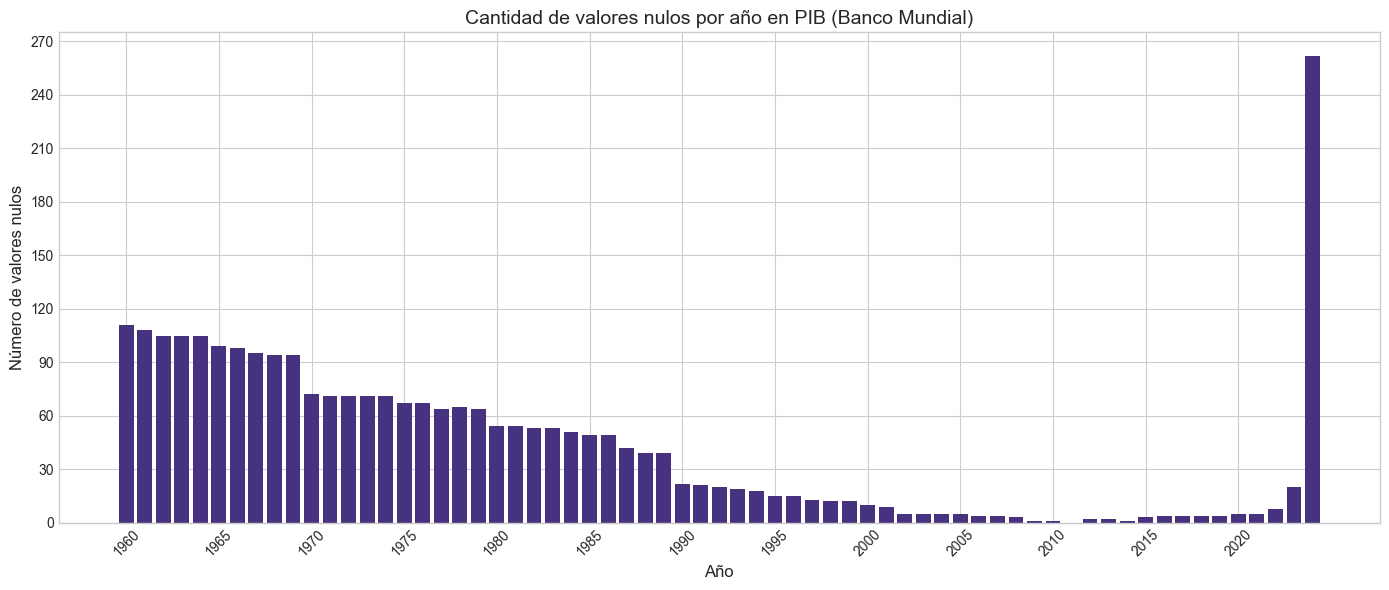

In [6]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# ==========================
# 0) Ruta del archivo PIB (Banco Mundial)
#    Cambia esta ruta si usas otra ubicación/nombre
# ==========================
gdp_path = '../../data/fuentes/economicos/API_NY.GDP.MKTP.CD_DS2_en_excel_v2_85096.xls'  # o .xlsx

# ==========================
# 1) Carga robusta del Excel (soporta .xls y .xlsx)
#    - Los excels del BM suelen tener la hoja "Data" y 3 filas de metadatos
# ==========================
ext = os.path.splitext(gdp_path)[1].lower()

read_kwargs = dict(sheet_name='Data', skiprows=3)
if ext == '.xlsx':
    # openpyxl sirve para .xlsx
    df_gdp = pd.read_excel(gdp_path, engine='openpyxl', **read_kwargs)
elif ext == '.xls':
    # Requiere xlrd para .xls (formato BIFF)
    try:
        df_gdp = pd.read_excel(gdp_path, engine='xlrd', **read_kwargs)
    except Exception as e:
        raise RuntimeError(
            "Para leer archivos .xls necesitas instalar 'xlrd'. "
            "Opciones: pip install xlrd==1.2.0 (o superior compatible) "
            "o convierte el archivo a .xlsx y vuelve a ejecutar.\n"
            f"Error original: {e}"
        )
else:
    raise ValueError(f"Extensión no soportada: {ext}. Usa .xls o .xlsx.")

# ==========================
# 2) Identificar columnas de años
#    (en BM suelen ser columnas enteras 1960..2023, etc.)
# ==========================
year_cols = [c for c in df_gdp.columns if isinstance(c, int)]
# fallback por si vinieran como strings:
if not year_cols:
    year_cols = [c for c in df_gdp.columns if str(c).isdigit()]
    # convertir a int para orden corrector
    df_gdp.rename(columns={c:int(c) for c in year_cols}, inplace=True)
    year_cols = [int(c) for c in year_cols]

year_cols = sorted(year_cols)

# ==========================
# 3) (Opcional pero recomendado) Eliminar filas totalmente vacías en los años
# ==========================
mask_all_empty_years = df_gdp[year_cols].isna().all(axis=1)
# Si quieres ver cuáles son:
# display(df_gdp.loc[mask_all_empty_years, ['Country Name','Country Code'] if están presentes])
df_gdp_clean = df_gdp.loc[~mask_all_empty_years].reset_index(drop=True)

# ==========================
# 4) Calcular nulos totales por año
# ==========================
nulos_por_anio_gdp = df_gdp_clean[year_cols].isna().sum()
# Si prefieres una Serie con índice str:
nulos_por_anio_gdp.index = nulos_por_anio_gdp.index.astype(int)

# ==========================
# 5) Graficar nulos por año (eje Y en enteros, X cada 5 años)
# ==========================
plt.figure(figsize=(14,6))
plt.bar(nulos_por_anio_gdp.index.astype(str), nulos_por_anio_gdp.values)

# ticks del eje X cada 5 años
xticks = nulos_por_anio_gdp.index.astype(str)[::5]
plt.xticks(xticks, rotation=45)

# eje Y solo enteros
plt.gca().yaxis.set_major_locator(MaxNLocator(integer=True))

plt.title("Cantidad de valores nulos por año en PIB (Banco Mundial)")
plt.xlabel("Año")
plt.ylabel("Número de valores nulos")
plt.tight_layout()
plt.show()

# ==========================
# 6) (Opcional) Exportar la Serie a Excel/CSV
# ==========================
# nulos_por_anio_gdp.to_excel('../../data/resultados/nulos_por_anio_pib.xlsx', sheet_name='Nulos_PIB')
# nulos_por_anio_gdp.to_csv('../../data/resultados/nulos_por_anio_pib.csv', header=['nulos'], index_label='anio')


LIMPIEZA DE PIB

In [4]:
# Limpieza y transformación del dataset de PIB
print("Limpieza del dataset de PIB:")
print(f"Filas antes de la limpieza: {df_pib.shape[0]}")

# Seleccionar solo las columnas necesarias (país, código y años)
# Primero identificamos las columnas de años (que son numéricas)
year_columns = [col for col in df_pib.columns if str(col).isdigit()]
selected_columns = ['Country Name', 'Country Code'] + year_columns
df_pib_clean = df_pib[selected_columns]

# Transformar de formato ancho a formato largo
df_pib_long = pd.melt(
    df_pib_clean,
    id_vars=['Country Name', 'Country Code'],
    value_vars=year_columns,
    var_name='anio',
    value_name='pib'
)

# Convertir año a entero
df_pib_long['anio'] = df_pib_long['anio'].astype(int)

# Eliminar filas con valores nulos de PIB
df_pib_long = df_pib_long.dropna(subset=['pib'])
print(f"Filas después de eliminar valores nulos: {df_pib_long.shape[0]}")

# Renombrar columnas para mayor claridad
df_pib_long = df_pib_long.rename(columns={
    'Country Name': 'pais',
    'Country Code': 'codigo_pais'
})

# Mostrar el dataset transformado
print("\nDataset de PIB transformado:")
display(df_pib_long.head())

Limpieza del dataset de PIB:
Filas antes de la limpieza: 266
Filas después de eliminar valores nulos: 14307

Dataset de PIB transformado:


,pais,codigo_pais,anio,pib
1,Africa Eastern and Southern,AFE,1960,2.421063e+10
3,Africa Western and Central,AFW,1960,1.190495e+10
13,Australia,AUS,1960,1.860768e+10
14,Austria,AUT,1960,6.624086e+09
16,Burundi,BDI,1960,1.960000e+08


Estadísticas descriptivas del PIB:


count    1.430700e+04
mean     1.184720e+12
std      5.489324e+12
min      2.585956e+06
25%      2.293505e+09
50%      1.692109e+10
75%      2.013025e+11
max      1.061717e+14
Name: pib, dtype: float64


Rango de años disponibles: 1960 - 2023
Número de países en el dataset: 262


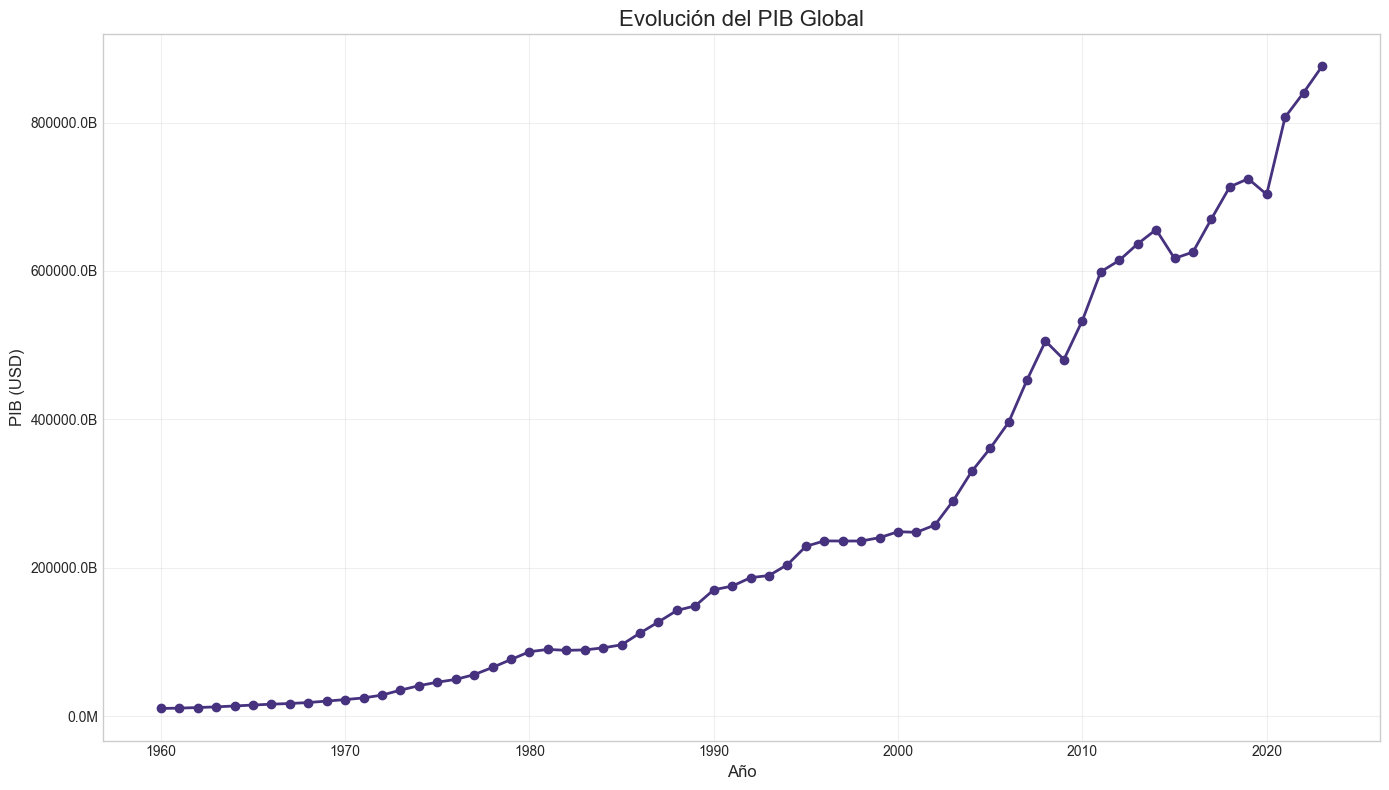

In [5]:
# Estadísticas descriptivas del PIB
print("Estadísticas descriptivas del PIB:")
display(df_pib_long['pib'].describe())

# Rango de años disponibles
print(f"\nRango de años disponibles: {df_pib_long['anio'].min()} - {df_pib_long['anio'].max()}")

# Número de países en el dataset
num_paises_pib = df_pib_long['pais'].nunique()
print(f"Número de países en el dataset: {num_paises_pib}")

# Evolución del PIB global a lo largo del tiempo
pib_global = df_pib_long.groupby('anio')['pib'].sum().reset_index()

plt.figure(figsize=(14, 8))
plt.plot(pib_global['anio'], pib_global['pib'], marker='o', linewidth=2)
plt.title('Evolución del PIB Global', fontsize=16)
plt.xlabel('Año', fontsize=12)
plt.ylabel('PIB (USD)', fontsize=12)
plt.grid(True, alpha=0.3)

# Formatear eje y en billones
plt.gca().yaxis.set_major_formatter(FuncFormatter(formato_miles_millones))

plt.tight_layout()
plt.show()